In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers,callbacks
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tensorflow.keras.preprocessing import image


from PIL import Image
from collections import Counter
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil


# Transfer Learning 
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam


# Exploratory Data Analysis (EDA) Questions

## 1. Data Structure and Integrity
- How many classes (blood cell types) are there in the dataset?
- How many images are available per class?

## 2. Image Properties
- What are the dimensions of the images?
- Are all images of consistent size or do they need resizing?
- Are there any grayscale or different color channels present?




In [205]:
data_dir = r'..\Dataset\Train'


In [204]:
classes = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print("Number of classes:", len(classes))
print("Class names:", classes)


Number of classes: 5
Class names: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


In [206]:
corrupted = []

for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception:
            corrupted.append(img_path)

print(f"Corrupted images found: {len(corrupted)}")
for path in corrupted:
    print(path)


Corrupted images found: 0


In [207]:
for cls in classes:
    num_images = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {num_images} images")


Basophil: 212 images
Eosinophil: 744 images
Lymphocyte: 2427 images
Monocyte: 561 images
Neutrophil: 6231 images


In [208]:
classes = os.listdir(data_dir)
sizes = []

for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder)[:2000]:  
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)  
        except:
            continue

print("Most common image sizes:", Counter(sizes).most_common(5))


Most common image sizes: [((575, 575), 5517)]


In [209]:
unique_sizes = set(sizes)
print(f"Unique image sizes: {len(unique_sizes)}")
if len(unique_sizes) == 1:
    print("All images are of consistent size.")
else:
    print(" Images vary in size and should be resized before training.")


Unique image sizes: 1
All images are of consistent size.


In [210]:
channel_counts = []

for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder)[:100]:
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            mode = img.mode  # e.g., 'RGB', 'L', 'RGBA'
            channel_counts.append(mode)
        except:
            continue

print("Color mode counts:", Counter(channel_counts))


Color mode counts: Counter({'RGB': 500})


#  EDA Summary

- **Classes**: 5 → *BASOPHIL,EOSINOPHIL, LYMPHOCYTE, MONOCYTE, NEUTROPHIL*  
- **Image Count**: Dataset is **imbalanced**, so augmentation is applied to balance it  
- **Corrupted Images**: ✅ None found  
- **Image Size**: 570×570 (consistent across all images)  
- **Color Mode**: All images are in **RGB** (3 channels)

### ✅ Conclusion
The dataset is clean and balanced after augmentation. It's ready for CNN training without needing any resizing or color mode adjustments.


# Train Data Balanced(Images Augmentation)

In [214]:

# Original data directory
source_dir = r"../Dataset/Train"
# Directory to save balanced dataset
balanced_dir = "../Dataset/Balanced_Train"

# Create new balanced dataset directory
if not os.path.exists(balanced_dir):
    os.makedirs(balanced_dir)

# Define augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count images in each class
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Target count = max class (Neutrophil: 6231)
target_count = max(class_counts.values())

print("Original class distribution:", class_counts)

# Augment each class to match target_count
for class_name, count in class_counts.items():
    print(f"\nProcessing {class_name}...")
    src_class_dir = os.path.join(source_dir, class_name)
    dst_class_dir = os.path.join(balanced_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    # Copy original images
    for fname in os.listdir(src_class_dir):
        shutil.copy(os.path.join(src_class_dir, fname), os.path.join(dst_class_dir, fname))

    # If underrepresented, generate more
    if count < target_count:
        needed = target_count - count
        image_files = os.listdir(src_class_dir)
        generated = 0

        while generated < needed:
            for fname in image_files:
                if generated >= needed:
                    break

                img_path = os.path.join(src_class_dir, fname)
                img = load_img(img_path)  # Load PIL image
                x = img_to_array(img)     # Convert to numpy array
                x = x.reshape((1,) + x.shape)  # Reshape for generator

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    save_path = os.path.join(dst_class_dir, f"aug_{generated}_{fname}")
                    array_to_img(batch[0]).save(save_path)
                    generated += 1
                    break

        print(f"✅ Generated {generated} images for {class_name}.")

print("\n✅ All classes augmented to have", target_count, "images each.")


Original class distribution: {'Basophil': 212, 'Eosinophil': 744, 'Lymphocyte': 2427, 'Monocyte': 561, 'Neutrophil': 6231}

Processing Basophil...
✅ Generated 6019 images for Basophil.

Processing Eosinophil...
✅ Generated 5487 images for Eosinophil.

Processing Lymphocyte...
✅ Generated 3804 images for Lymphocyte.

Processing Monocyte...
✅ Generated 5670 images for Monocyte.

Processing Neutrophil...

✅ All classes augmented to have 6231 images each.


# LOAD DATA

In [12]:
IMG_HEIGHT = 350
IMG_WIDTH = 350
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 123

train_dir = r'../Dataset/Balanced_Train'
test_dir = r'../Dataset/Test'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)



train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

class_names = test_ds_raw.class_names


Found 31155 files belonging to 5 classes.
Using 24924 files for training.
Found 31155 files belonging to 5 classes.
Using 6231 files for validation.
Found 4339 files belonging to 5 classes.


# CNN Model

In [228]:
model_1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(350, 350, 3)),

    layers.Conv2D(4, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    



    layers.Flatten(),

    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(5, activation='softmax')  
])


In [229]:
model_1.compile(loss='categorical_crossentropy',optimizer='adamW',metrics=['accuracy'])

In [230]:
checkpoint = ModelCheckpoint(
    filepath=r'..\Model\best_mode_1.h5',
    monitor='val_accuracy',        
    save_best_only=True,
    save_weights_only=False,       
    mode='max',                    
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, earlystop]

In [231]:
model_1.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=callbacks)

Epoch 1/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8197 - loss: 0.5349
Epoch 1: val_accuracy improved from -inf to 0.70743, saving model to ..\Model\best_mode_1.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 188s 119ms/step - accuracy: 0.8197 - loss: 0.5348 - val_accuracy: 0.7074 - val_loss: 1.1415
Epoch 2/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9474 - loss: 0.1617
Epoch 2: val_accuracy improved from 0.70743 to 0.81062, saving model to ..\Model\best_mode_1.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 158s 102ms/step - accuracy: 0.9474 - loss: 0.1617 - val_accuracy: 0.8106 - val_loss: 0.7745
Epoch 3/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9618 - loss: 0.1172
Epoch 3: val_accuracy improved from 0.81062 to 0.94672, saving model to ..\Model\best_mode_1.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.9618 - loss: 0.1172 - val_accuracy: 0.9467 - val_loss: 0.1713
Epoch 4/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9762 - loss: 0.0749
Epoch 4: val_accuracy did not improve from 0.94672
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.9762 - loss: 0.0749 - val_accuracy: 0.8950 - val_loss: 0.3088
Epoch 5/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9816 - loss: 0.0543
Epoch 5: val_accuracy did not improve from 0.94672
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.9816 - loss: 0.0543 - val_accuracy: 0.9372 - val_loss: 0.2519
Epoch 6/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9845 - loss: 0.0456
Epoch 6: val_accuracy improved from 0.94672 to 0.96084, saving model to ..\Model\best_mode_1.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.9845 - loss: 0.0456 - val_accuracy: 0.9608 - val_loss: 0.1329
Epoch 7/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9884 - loss: 0.0357
Epoch 7: val_accuracy did not improve from 0.96084
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 442s 284ms/step - accuracy: 0.9884 - loss: 0.0357 - val_accuracy: 0.9591 - val_loss: 0.1493
Epoch 8/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9888 - loss: 0.0331
Epoch 8: val_accuracy did not improve from 0.96084
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.9888 - loss: 0.0331 - val_accuracy: 0.2237 - val_loss: 98.5444
Epoch 9/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9880 - loss: 0.0355
Epoch 9: val_accuracy did not improve from 0.96084
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - accuracy: 0.9880 - loss: 0.0355 - val_accuracy: 0.3823 - val_loss: 11.0962
Epoch 10/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9900 - loss: 0

In [32]:
model_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(350, 350, 3)),

    layers.Conv2D(4, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    



    layers.Flatten(),

    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(5, activation='softmax')  
])


d:\Anaconda\envs\dl_py\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model_2.compile(loss='categorical_crossentropy',optimizer='adamW',metrics=['accuracy'])

In [34]:
checkpoint = ModelCheckpoint(
    filepath=r'..\Model\best_mode_2.h5',
    monitor='val_accuracy',        
    save_best_only=True,
    save_weights_only=False,       
    mode='max',                    
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, earlystop]

In [35]:
model_2.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=callbacks)

Epoch 1/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8101 - loss: 0.5982
Epoch 1: val_accuracy improved from -inf to 0.88974, saving model to ..\Model\best_mode_2.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 119s 74ms/step - accuracy: 0.8102 - loss: 0.5979 - val_accuracy: 0.8897 - val_loss: 0.3185
Epoch 2/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9337 - loss: 0.2042
Epoch 2: val_accuracy improved from 0.88974 to 0.95587, saving model to ..\Model\best_mode_2.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - accuracy: 0.9337 - loss: 0.2042 - val_accuracy: 0.9559 - val_loss: 0.1365
Epoch 3/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9551 - loss: 0.1389
Epoch 3: val_accuracy did not improve from 0.95587
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.9551 - loss: 0.1389 - val_accuracy: 0.9459 - val_loss: 0.1600
Epoch 4/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9669 - loss: 0.1082
Epoch 4: val_accuracy did not improve from 0.95587
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 122s 79ms/step - accuracy: 0.9669 - loss: 0.1082 - val_accuracy: 0.8705 - val_loss: 0.4339
Epoch 5/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9687 - loss: 0.1001
Epoch 5: val_accuracy did not improve from 0.95587
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.9687 - loss: 0.1000 - val_accuracy: 0.7943 - val_loss: 0.6875
Epoch 6/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9757 - loss: 0.0740

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.9757 - loss: 0.0740 - val_accuracy: 0.9560 - val_loss: 0.1539
Epoch 7/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9802 - loss: 0.0599
Epoch 7: val_accuracy improved from 0.95603 to 0.96421, saving model to ..\Model\best_mode_2.h5


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - accuracy: 0.9802 - loss: 0.0599 - val_accuracy: 0.9642 - val_loss: 0.1320
Epoch 8/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9830 - loss: 0.0531
Epoch 8: val_accuracy did not improve from 0.96421
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.9830 - loss: 0.0531 - val_accuracy: 0.9636 - val_loss: 0.1308
Epoch 9/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9867 - loss: 0.0417
Epoch 9: val_accuracy did not improve from 0.96421
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - accuracy: 0.9867 - loss: 0.0417 - val_accuracy: 0.9490 - val_loss: 0.1811
Epoch 10/100
1557/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9875 - loss: 0.0396
Epoch 10: val_accuracy did not improve from 0.96421
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.9875 - loss: 0.0396 - val_accuracy: 0.8931 - val_loss: 0.4029
Epoch 11/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9822 - loss: 0.

In [51]:
model_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(350, 350, 3)),

    layers.Conv2D(4, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    
    layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),


    layers.Flatten(),

    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(5, activation='softmax')  
])


d:\Anaconda\envs\dl_py\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
model_3.compile(loss='categorical_crossentropy',optimizer='adamW',metrics=['accuracy'])

In [53]:
checkpoint = ModelCheckpoint(
    filepath=r'..\Model\best_mode_3.h5',
    monitor='val_accuracy',        
    save_best_only=True,
    save_weights_only=False,       
    mode='max',                    
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, earlystop]

In [54]:
model_3.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=callbacks)

Epoch 1/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8362 - loss: 0.5181
Epoch 1: val_accuracy improved from -inf to 0.50666, saving model to ..\Model\best_mode_3.h5
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 143s 89ms/step - accuracy: 0.8362 - loss: 0.5180 - val_accuracy: 0.5067 - val_loss: 2.9978
Epoch 2/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9422 - loss: 0.1725
Epoch 2: val_accuracy improved from 0.50666 to 0.94993, saving model to ..\Model\best_mode_3.h5
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.9422 - loss: 0.1725 - val_accuracy: 0.9499 - val_loss: 0.1535
Epoch 3/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9607 - loss: 0.1219
Epoch 3: val_accuracy did not improve from 0.94993
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.9607 - loss: 0.1218 - val_accuracy: 0.9149 - val_loss: 0.2501
Epoch 4/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9668 - loss: 0.1009
Epoch 4: val_accuracy did not impr

As we can see, changing the **CNN architecture** results in different accuracy levels. You have to **adjust the architecture according to your requirements** to **reach maximum accuracy**.


In [ ]:
model = models.load_model(r"D:\Internship\Blood_Type_Classification_CNN\Model\best_mode_3.h5") 

272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Test Accuracy: 0.9318


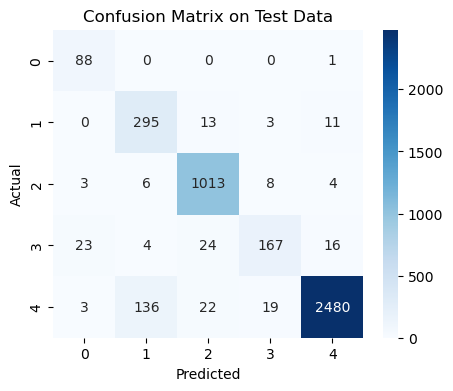

              precision    recall  f1-score   support

    Basophil       0.75      0.99      0.85        89
  Eosinophil       0.67      0.92      0.77       322
  Lymphocyte       0.94      0.98      0.96      1034
    Monocyte       0.85      0.71      0.77       234
  Neutrophil       0.99      0.93      0.96      2660

    accuracy                           0.93      4339
   macro avg       0.84      0.91      0.86      4339
weighted avg       0.94      0.93      0.93      4339



In [56]:
# Predict
y_pred = model.predict(test_ds)
y_pred_classes = y_pred.argmax(axis=1)

# Get true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)
y_true = np.argmax(y_true, axis=1)  

# Accuracy
acc = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {acc:.4f}") 

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Real Time Predicition

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


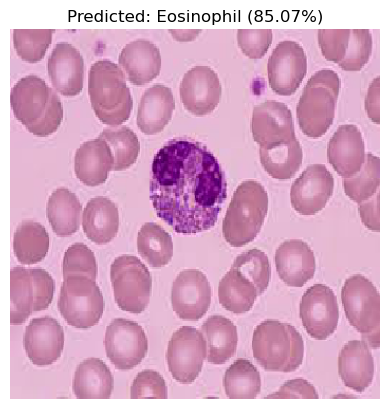

Predicted Class: Eosinophil


In [63]:
class_names = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

def predict_image_class(img_path):
    img = image.load_img(img_path, target_size=(350, 350))  
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    return predicted_class

img_path = r"C:\Users\dell\Downloads\Eosinophil.jpeg"  
predicted_class = predict_image_class(img_path)
print(f"Predicted Class: {predicted_class}")


# Transfer Learning

**Transfer learning** is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second, related task. It leverages pre-trained models, saving time and improving performance, especially when training data is limited.

However, **remember** that transfer learning does **not always guarantee higher accuracy** compared to a well-designed custom **CNN architecture**. In some cases, your own CNN model may perform better depending on the specific dataset and task.



In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 123

train_dir = r'../Dataset/Balanced_Train'
test_dir = r'../Dataset/Test'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)



train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

class_names = test_ds_raw.class_names


Found 31155 files belonging to 5 classes.
Using 24924 files for training.
Found 31155 files belonging to 5 classes.
Using 6231 files for validation.
Found 4339 files belonging to 5 classes.


## **MobileNetV2**

In [ ]:


# Base model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Transfer learning model
model_mobile_1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Better than Flatten
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')  # 5 classes
])

model_mobile_1.compile(optimizer='AdamW', loss='categorical_crossentropy', metrics=['accuracy'])


# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    ModelCheckpoint(r'..\Model\mobile_model_1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

# Train
model_mobile_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8035 - loss: 0.5491
Epoch 1: val_accuracy improved from -inf to 0.91077, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 496s 631ms/step - accuracy: 0.8036 - loss: 0.5489 - val_accuracy: 0.9108 - val_loss: 0.2417 - learning_rate: 0.0010
Epoch 2/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9234 - loss: 0.2232
Epoch 2: val_accuracy improved from 0.91077 to 0.93003, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 500s 642ms/step - accuracy: 0.9234 - loss: 0.2232 - val_accuracy: 0.9300 - val_loss: 0.1922 - learning_rate: 0.0010
Epoch 3/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9365 - loss: 0.1792
Epoch 3: val_accuracy improved from 0.93003 to 0.93532, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 535s 687ms/step - accuracy: 0.9365 - loss: 0.1792 - val_accuracy: 0.9353 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 4/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9426 - loss: 0.1578
Epoch 4: val_accuracy improved from 0.93532 to 0.94094, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 531s 682ms/step - accuracy: 0.9426 - loss: 0.1577 - val_accuracy: 0.9409 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 5/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9474 - loss: 0.1487
Epoch 5: val_accuracy did not improve from 0.94094
779/779 ━━━━━━━━━━━━━━━━━━━━ 670s 860ms/step - accuracy: 0.9474 - loss: 0.1487 - val_accuracy: 0.9292 - val_loss: 0.2062 - learning_rate: 0.0010
Epoch 6/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9508 - loss: 0.1360
Epoch 6: val_accuracy did not improve from 0.94094
779/779 ━━━━━━━━━━━━━━━━━━━━ 494s 633ms/step - accuracy: 0.9508 - loss: 0.1360 - val_accuracy: 0.9032 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 7/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9522 - loss: 0.1301
Epoch 7: val_accuracy improved from 0.94094 to 0.94335, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 506s 649ms/step - accuracy: 0.9522 - loss: 0.1301 - val_accuracy: 0.9433 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 8/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9604 - loss: 0.1149
Epoch 8: val_accuracy improved from 0.94335 to 0.94479, saving model to mobile_model_1.h5


779/779 ━━━━━━━━━━━━━━━━━━━━ 525s 674ms/step - accuracy: 0.9604 - loss: 0.1149 - val_accuracy: 0.9448 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 9/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9587 - loss: 0.1120
Epoch 9: val_accuracy did not improve from 0.94479
779/779 ━━━━━━━━━━━━━━━━━━━━ 561s 721ms/step - accuracy: 0.9587 - loss: 0.1120 - val_accuracy: 0.9305 - val_loss: 0.2127 - learning_rate: 0.0010
Epoch 10/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9591 - loss: 0.1092
Epoch 10: val_accuracy did not improve from 0.94479
779/779 ━━━━━━━━━━━━━━━━━━━━ 460s 591ms/step - accuracy: 0.9591 - loss: 0.1092 - val_accuracy: 0.9241 - val_loss: 0.2152 - learning_rate: 0.0010


In [8]:
model = models.load_model(r"D:\Internship\Blood_Type_Classification_CNN\Notebook\mobile_model_1.h5") 

136/136 ━━━━━━━━━━━━━━━━━━━━ 66s 474ms/step
Test Accuracy: 0.8908


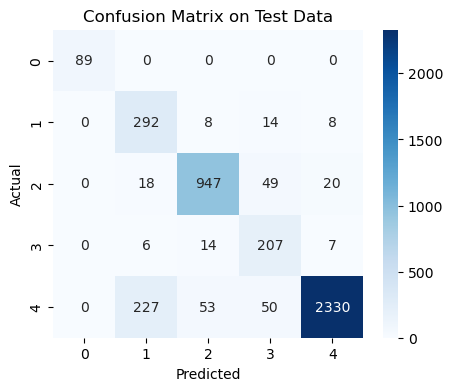

              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.54      0.91      0.68       322
  Lymphocyte       0.93      0.92      0.92      1034
    Monocyte       0.65      0.88      0.75       234
  Neutrophil       0.99      0.88      0.93      2660

    accuracy                           0.89      4339
   macro avg       0.82      0.92      0.85      4339
weighted avg       0.92      0.89      0.90      4339



In [9]:
# Predict
y_pred = model.predict(test_ds)
y_pred_classes = y_pred.argmax(axis=1)

# Get true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)
y_true = np.argmax(y_true, axis=1)  

# Accuracy
acc = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {acc:.4f}") 

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


As we clearly see, we achieved **89% test accuracy** using **MobileNetV2**, which is a **transfer learning model**, while our **custom CNN** achieved a **higher accuracy of 93%**.

As mentioned above, transfer learning models do **not always guarantee better accuracy** than custom CNN architectures. You need to **experiment with different transfer learning models** to see if any of them outperform your custom solution — MobileNetV2 in this case.

Since this project is **not solely focused on transfer learning**, we did **not apply every available pre-trained model**.
